In [4]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD



# Compsci 361 Assignment 3

## Task 1: Exploratory data analytics on text data


### a) 

In [5]:
data_X = pd.read_csv("train.csv")
data_y = pd.read_csv("test.csv")
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()
tfid.fit(data_X["Text"])

tfidDF = tfid.transform(data_X["Text"])

#number of articles and features
num_articles = tfidDF.shape[0]
num_features = tfidDF.shape[1]

print(f"Number of articles: {num_articles}")
print(f"Number of extracted features: {num_features}")

#5 example articles
fivearticles = data_X["Text"].head(5)
features = tfidDF[:5].toarray()
feature_names = tfid.get_feature_names_out()

example_df = pd.DataFrame(features, columns=feature_names, index=fivearticles)

print(example_df.head())

Number of articles: 428
Number of extracted features: 13518
                                                     00       000  000th  \
Text                                                                       
lifestyle governs mobile choice faster better f...  0.0  0.020115    0.0   
french honour director parker british film dire...  0.0  0.000000    0.0   
fockers fuel festive film chart comedy meet foc...  0.0  0.000000    0.0   
housewives lift channel 4 ratings debut us tele...  0.0  0.000000    0.0   
u2 desire number one u2 three prestigious gramm...  0.0  0.000000    0.0   

                                                    001st  0051  007  0100  \
Text                                                                         
lifestyle governs mobile choice faster better f...    0.0   0.0  0.0   0.0   
french honour director parker british film dire...    0.0   0.0  0.0   0.0   
fockers fuel festive film chart comedy meet foc...    0.0   0.0  0.0   0.0   
housewives lift c

In [3]:
data_X["Category"].unique()

array(['tech', 'entertainment'], dtype=object)

For these articles, we peformed vectorisation using inverse document frequency as a way of tokenising the texts. From this, we observed 13518 unique words becoming our features from 428 articles.

### b)


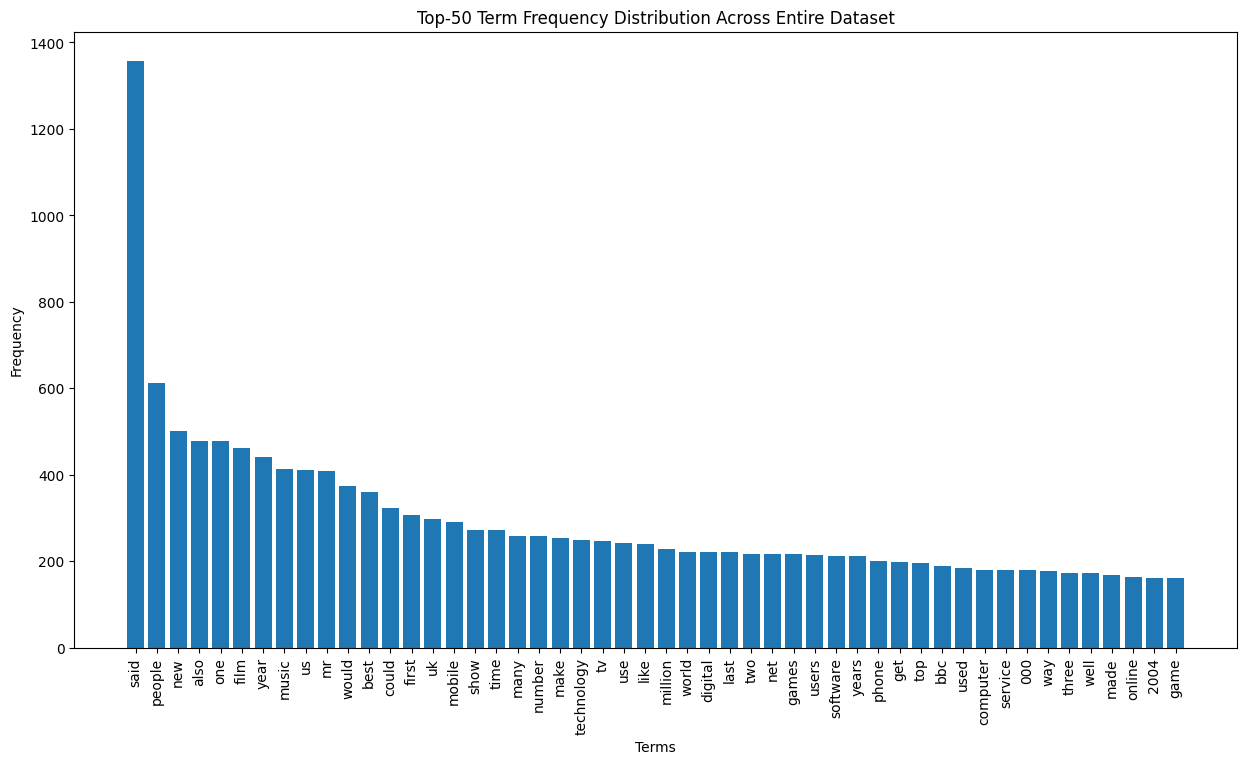

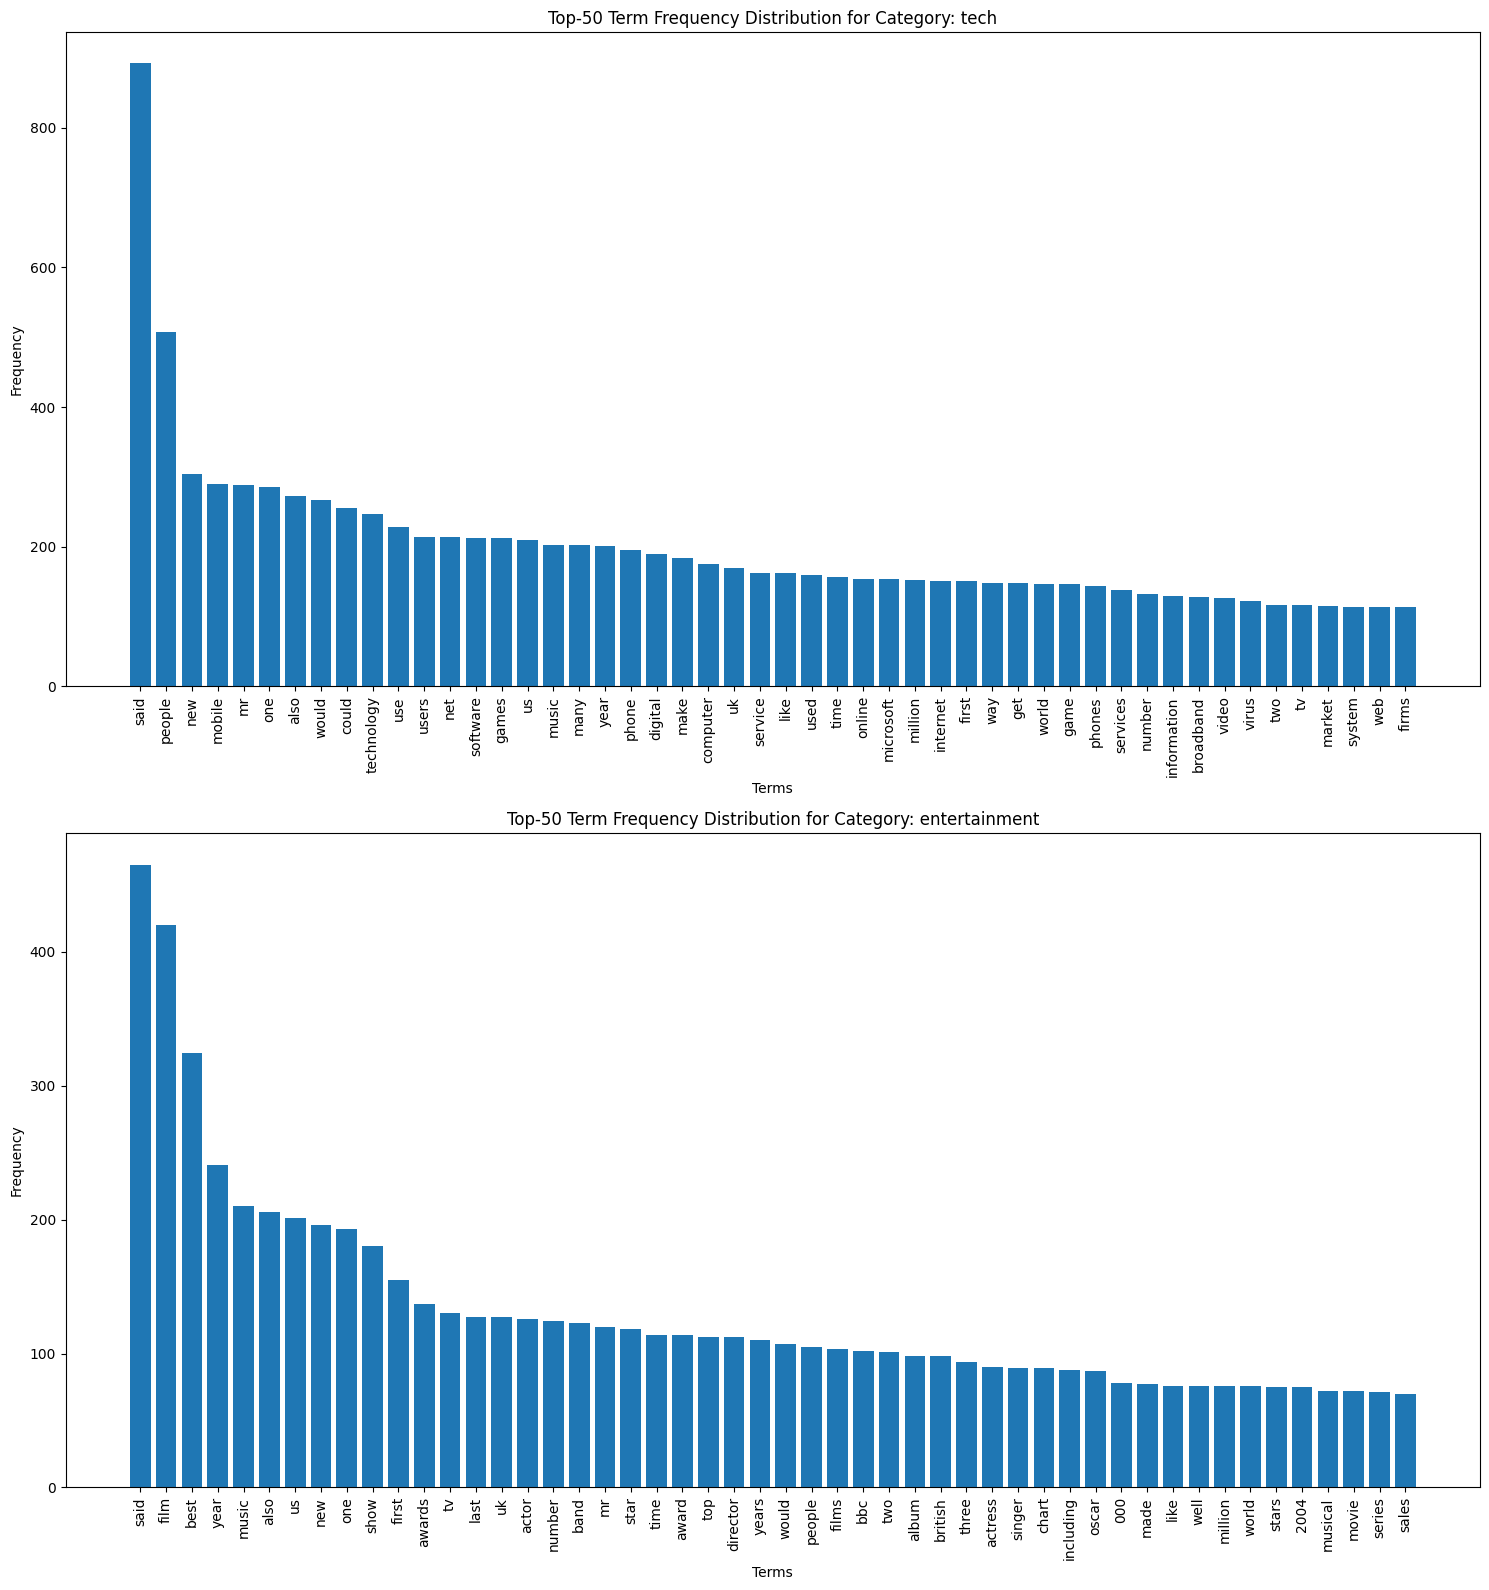

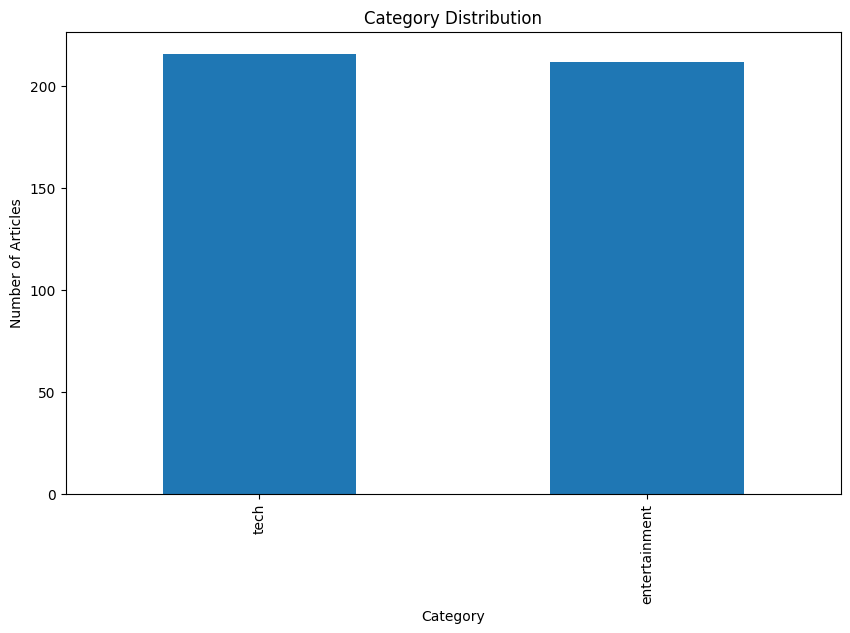

In [6]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

word_matrix = vectorizer.fit_transform(data_X["Text"])
word_hz = word_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame({'term': terms, 'frequency': word_hz})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

#plot 1
plt.figure(figsize=(15, 8))
top50 = term_freq_df.head(50)
plt.bar(top50['term'], top50['frequency'])
plt.xticks(rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution Across Entire Dataset')
plt.show()

categories = data_X['Category'].unique()
term_hz = {}

for category in categories:
    category_texts = data_X[data_X['Category'] == category]['Text']
    category_word_matrix = vectorizer.transform(category_texts)
    category_word_hz = category_word_matrix.sum(axis=0).A1
    term_hz[category] = category_word_hz

#plot 2&3
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 8 * len(categories)))

for i, category in enumerate(categories):
    term_freqDF = pd.DataFrame({'term': terms, 'frequency': term_hz[category]})
    term_freqDF = term_freqDF.sort_values(by='frequency', ascending=False)
    top50_terms = term_freqDF.head(50)
    
    axes[i].bar(top50_terms['term'], top50_terms['frequency'])
    axes[i].set_xticks(range(len(top50_terms['term'])))
    axes[i].set_xticklabels(top50_terms['term'], rotation=90)
    axes[i].set_xlabel('Terms')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Top-50 Term Frequency Distribution for Category: {category}')

plt.tight_layout()
plt.show()

#plot 4
plt.figure(figsize=(10, 6))
category_distribution = data_X['Category'].value_counts()
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Category Distribution')
plt.show()

From looking at the above plots, we notice "said' was mentioned the most frequently across all articles, surpassing the closest frequent word by over two times. The remaining top term frequencies seems quite consistent ranging from 600 down to 200. We also see "said" is most frequent in the category tech compared to entertainment. Overall, the data seems fairly balanced with similar number of articles for each category. 

## Task 2: Classification Models Learning

In [7]:
#Vectorizing after data split
X_train, X_test, y_train, y_test = train_test_split(data_X["Text"], data_X["Category"], test_size=0.2,random_state=42)

#Tfid Vectorizer
X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

#Count Vectorizer
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


Helper functions

In [8]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(pca, X, y, ax, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'o')
    colors = ('lightblue', 'orange')
    background = ('lightcyan', 'cornsilk')
    cmap = ListedColormap(colors)

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(pca.inverse_transform(
        np.array([xx1.ravel(), xx2.ravel()]).T)
        )
    # Convert levels to numbers
    Z = np.where(Z == "entertainment", 0, 1)
    Z = Z.reshape(xx1.shape)
    print(Z.shape)
    
    if ax is None: ax = plt.gca()
    
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('principle component 1', size=16)
    ax.set_ylabel('principle component 2', size=16)
    ax.legend(loc='upper left', fontsize=16)

    plt.show()

### a) Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

model.fit(X_train_count, y_train)
pred = model.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



### b) kNN

In [8]:
# finding the best 20 words:

log_probabilities = model.feature_log_prob_

words = vectorizer.get_feature_names_out()

change_log_probabilities = [abs(log_probabilities[0][i] - log_probabilities[1][i]) for i in range(len(log_probabilities[0]))]

value_order = np.argsort(change_log_probabilities)

best_20 = value_order[len(log_probabilities[0]) - 20:][::-1]

print(words[best_20])

['software' 'users' 'microsoft' 'singer' 'mobile' 'virus' 'oscar' 'band'
 'pc' 'firms' 'stars' 'broadband' 'rock' 'data' 'chart' 'album' 'actress'
 'nominations' 'gadget' 'festival']


In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Define parameters for GridSearchCV
knn_param_grid = {
    "n_neighbors": range(1, 50),
    "metric": ["euclidean", "manhattan", "minkowski", "cosine"]
}

# use cross validation to find optimal parameters k and distance metric
grid_search = GridSearchCV(knn, knn_param_grid, cv = 5)
grid_search.fit(X_train_count, y_train)
best_params = grid_search.best_params_
best_k = best_params["n_neighbors"]
best_metric = best_params["metric"]

print(f'Best parameters: k = {best_k}, metric = {best_metric}')

#best_k 



Best parameters: k = 20, metric = cosine


In [10]:
#best_k = 20
# best_metric = cosine
# train a knn classifier with the optimal parameters 
knn_best = KNeighborsClassifier(n_neighbors = best_k, metric = best_metric)
knn_best.fit(X_train_count, y_train)

y_pred_knn = knn_best.predict(X_test_count)

print("K-Nearest Neighbor:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbor:
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

entertainment       0.95      0.92      0.93        38
         tech       0.94      0.96      0.95        48

     accuracy                           0.94        86
    macro avg       0.94      0.94      0.94        86
 weighted avg       0.94      0.94      0.94        86



# KNN using tfidf

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_tfidf = KNeighborsClassifier()

# Define parameters for GridSearchCV
knn_tfidf_param_grid = {
    "n_neighbors": range(1, 50),
    "metric": ["euclidean","minkowski", "cosine"]
}

# use cross validation to find optimal parameters k and distance metric
grid_search = GridSearchCV(knn_tfidf, knn_tfidf_param_grid, cv = 5)
grid_search.fit(X_train_tfid, y_train)
best_params = grid_search.best_params_
best_k = best_params["n_neighbors"]
best_metric = best_params["metric"]

print(f'Best parameters: k = {best_k}, metric = {best_metric}')

#best_k 



Best parameters: k = 18, metric = euclidean


In [11]:
#best_k = 20
# best_metric = cosine
# train a knn classifier with the optimal parameters 
knn_best_tfidf = KNeighborsClassifier(n_neighbors = 18, metric = "euclidean")
knn_best_tfidf.fit(X_train_tfid, y_train)

y_train_knn_tfidf = knn_best_tfidf.predict(X_train_tfid)
y_test_knn_tfidf = knn_best_tfidf.predict(X_test_tfid)

print("K-Nearest Neighbor:")
print("Accuracy:", accuracy_score(y_test, y_test_knn_tfidf))
print("Classification Report:")
print(classification_report(y_test, y_test_knn_tfidf))

K-Nearest Neighbor:
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



## Surface plots

(62, 54)


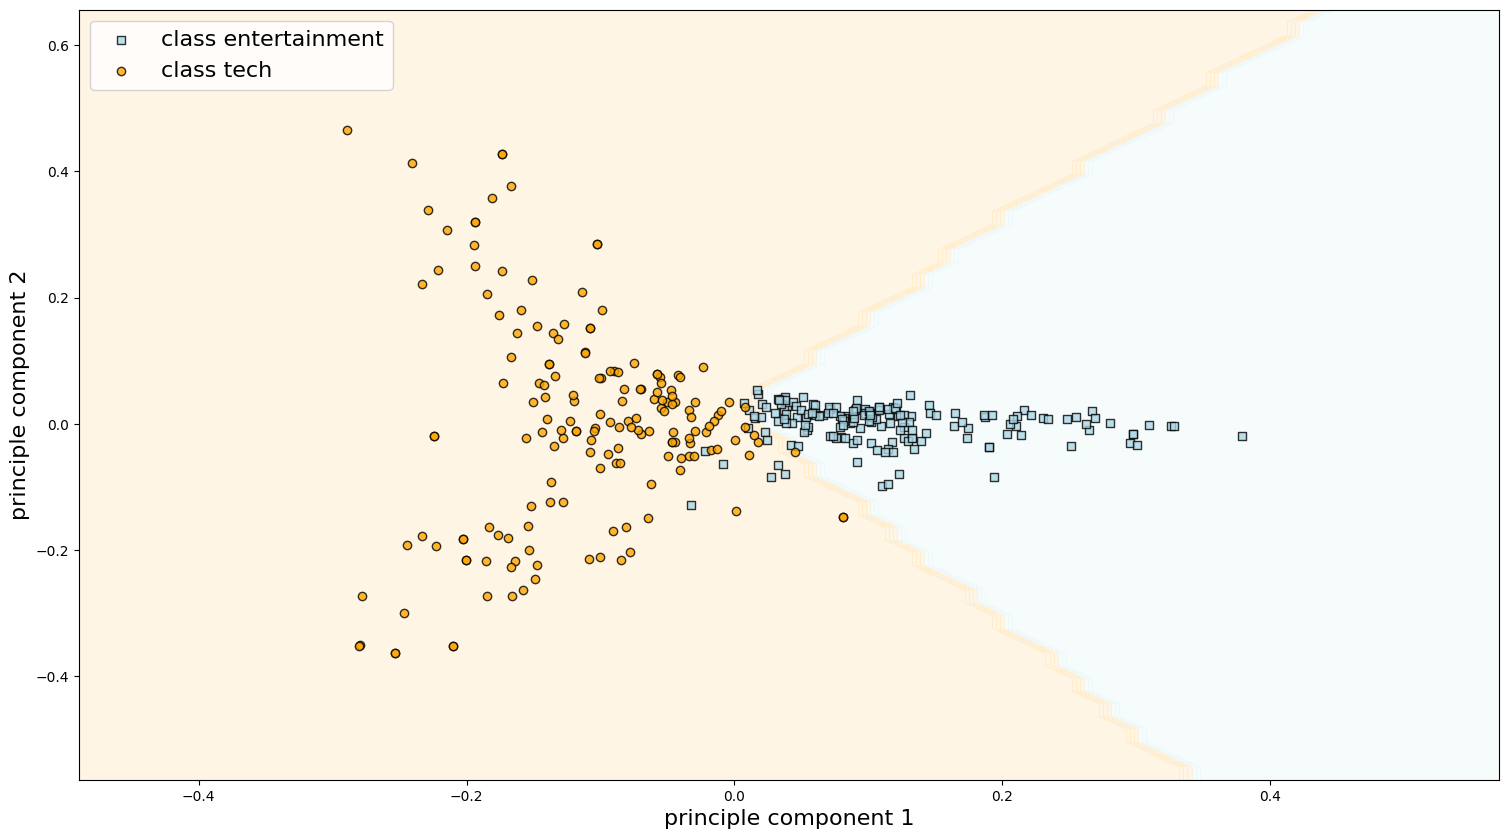

In [14]:
pca_knn = PCA(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(np.asarray(X_train_tfid.todense()))
pca_test_tfidf = pca_knn.transform(X_test_tfid)

fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_train_tfidf, y_train_knn_tfidf, ax_pca, knn_best_tfidf, test_idx=None, resolution=0.02)
# plot_decision_regions(pca_knn, pca_train_tfidf, y_train_knn_tfidf, ax_pca, knn_best_tfidf, test_idx=None, resolution=0.02)



# test index shows what rows of X are test, this means X is a combination of train and test



(56, 38)


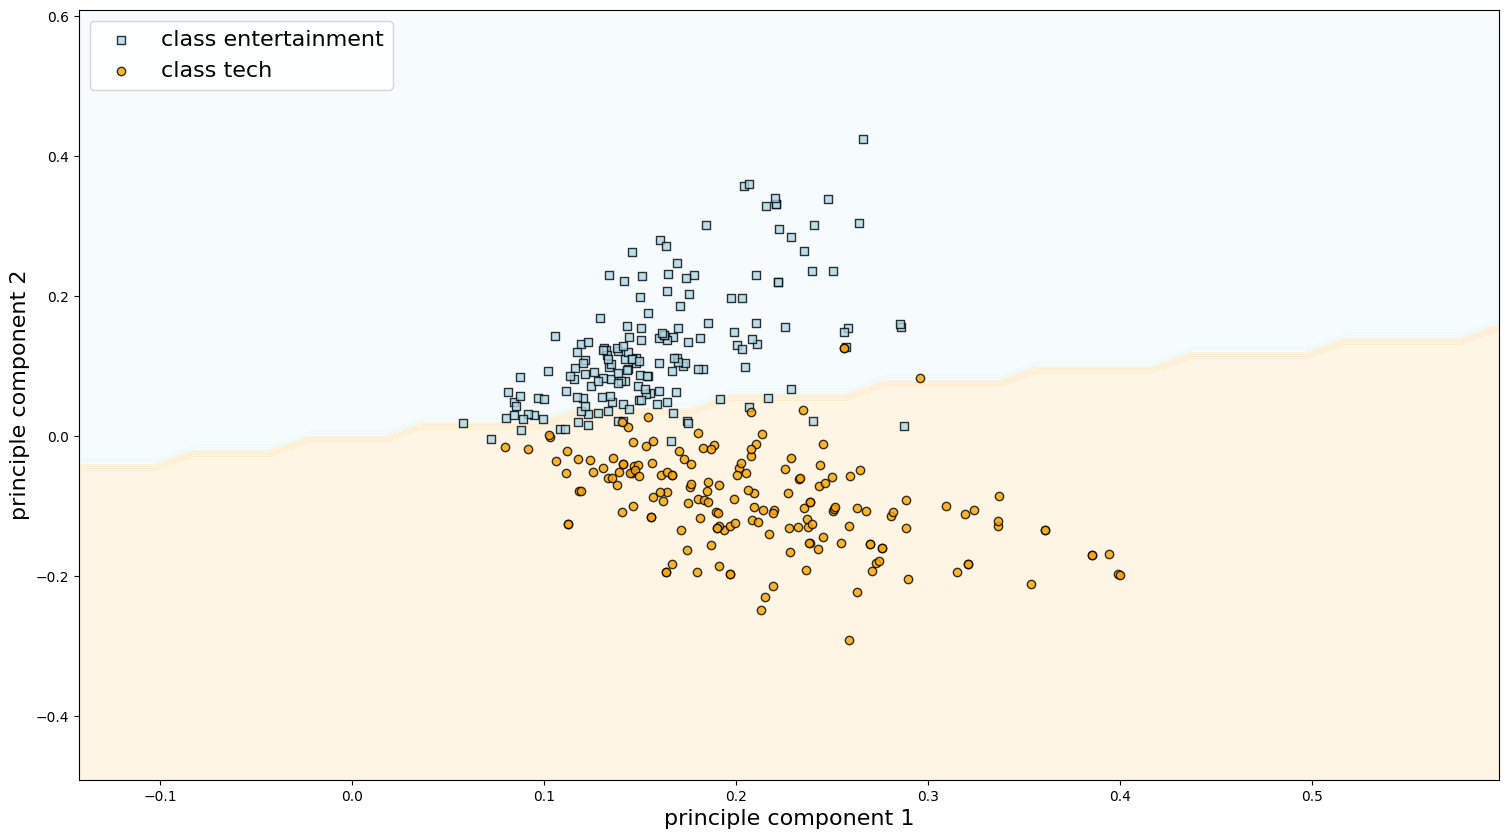

In [16]:
pca_knn_trunc = TruncatedSVD(n_components=2)
pca_train_tfidf_trunc = pca_knn_trunc.fit_transform(X_train_tfid)
pca_test_tfidf_trunc = pca_knn_trunc.transform(X_test_tfid)



fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn_trunc, pca_train_tfidf_trunc, y_train_knn_tfidf, ax_pca, knn_best_tfidf, test_idx=None, resolution=0.02)
# plot_decision_regions(pca_knn, pca_train_tfidf, y_train_knn_tfidf, ax_pca, knn_best_tfidf, test_idx=None, resolution=0.02)



# test index shows what rows of X are test, this means X is a combination of train and test



In [11]:
print(X_train_count.shape)
print(X_test_count.shape)
print()

(342, 12336)
(86, 12336)



### c) SVM

In [11]:
# soft SVM
from sklearn.svm import SVC

# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_count, y_train)

y_pred_linear = linear_svm.predict(X_test_count)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_linear))
print('Classification Report:')
print(classification_report(y_test, y_pred_linear))

Best C parameter: 0.01
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



# Soft svm tfidf

In [19]:
# soft SVM
from sklearn.svm import SVC

# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_tfid, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_tfid, y_train)

y_train_linear = linear_svm.predict(X_train_tfid)
y_test_linear = linear_svm.predict(X_test_tfid)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_test_linear))
print('Classification Report:')
print(classification_report(y_test, y_test_linear))

Best C parameter: 1
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



(62, 54)


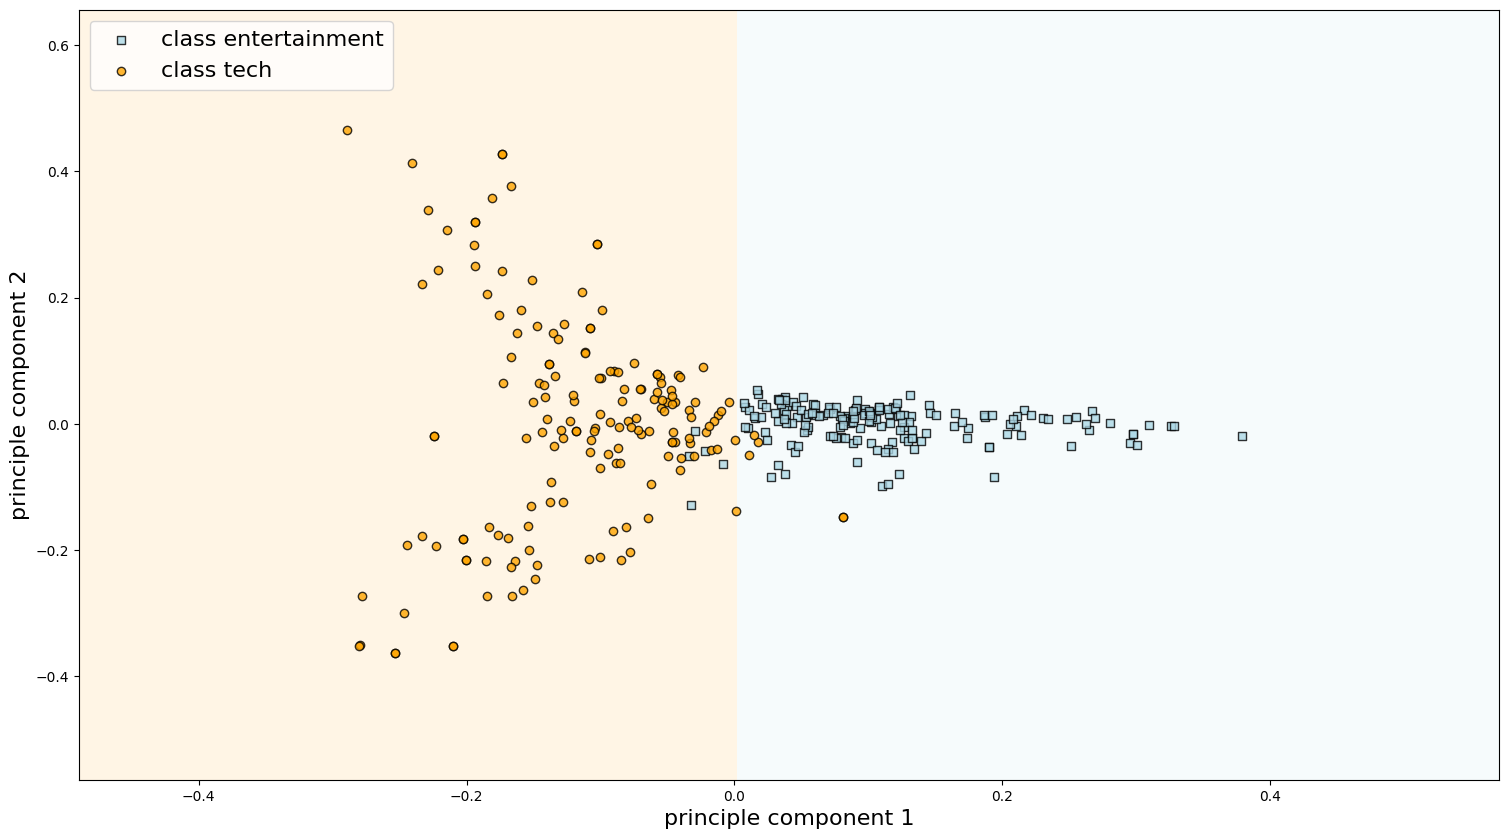

In [25]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_train_tfidf, y_train_linear, ax_pca, linear_svm, test_idx=None, resolution=0.02)


(56, 38)


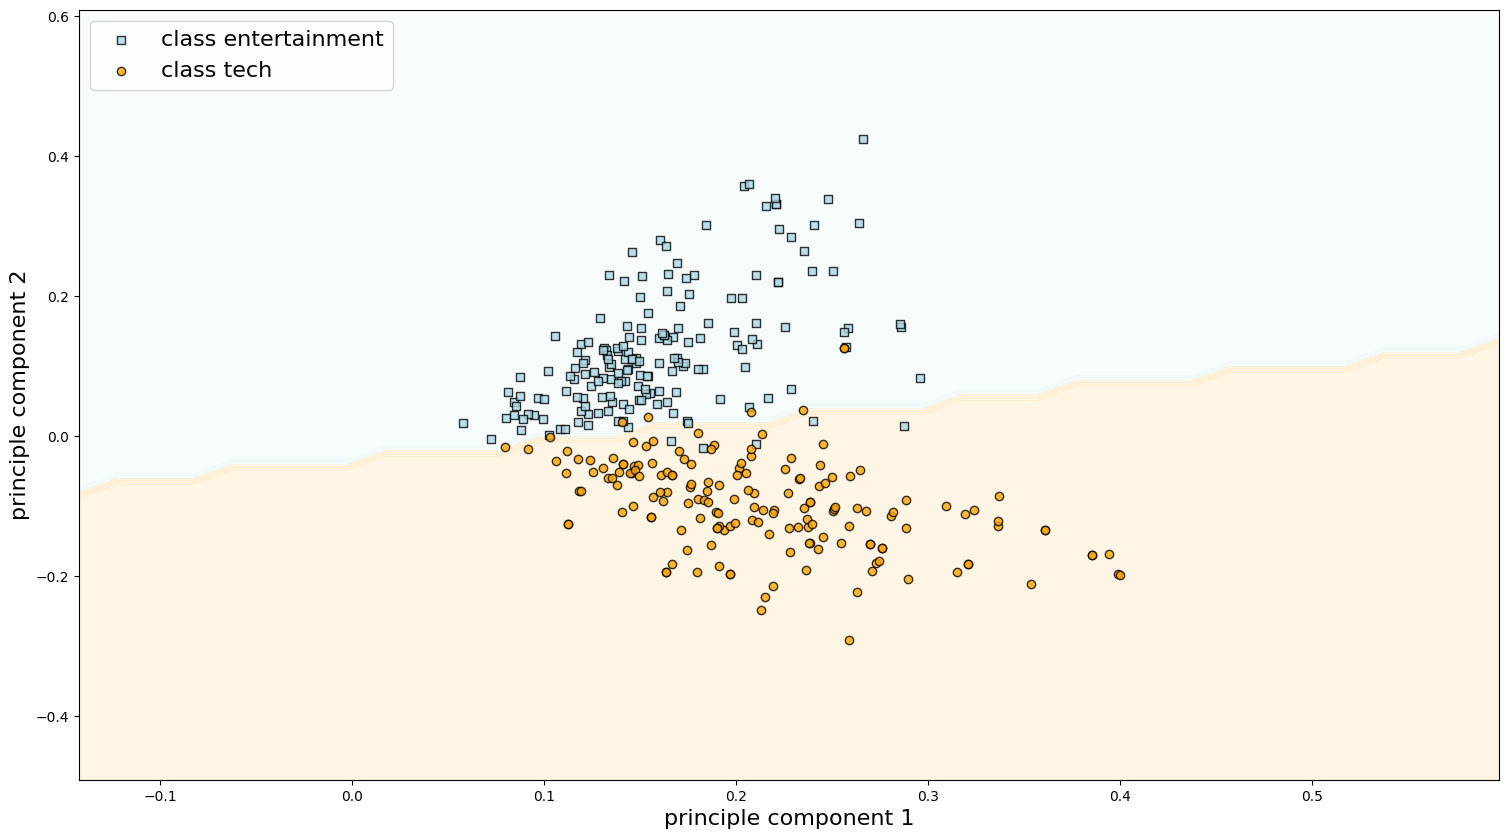

In [20]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn_trunc, pca_train_tfidf_trunc, y_train_linear, ax_pca, linear_svm, test_idx=None, resolution=0.02)


#### Hard-Margin RBF with varying kernel width


In [12]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_count, y_train)

y_pred_rbf = rbf_svm.predict(X_test_count)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 0.001
Hard-Margin RBF SVM:
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [21]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_tfid, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_tfid, y_train)

y_train_rbf = rbf_svm.predict(X_train_tfid)
y_pred_rbf = rbf_svm.predict(X_test_tfid)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 1
Hard-Margin RBF SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



(62, 54)


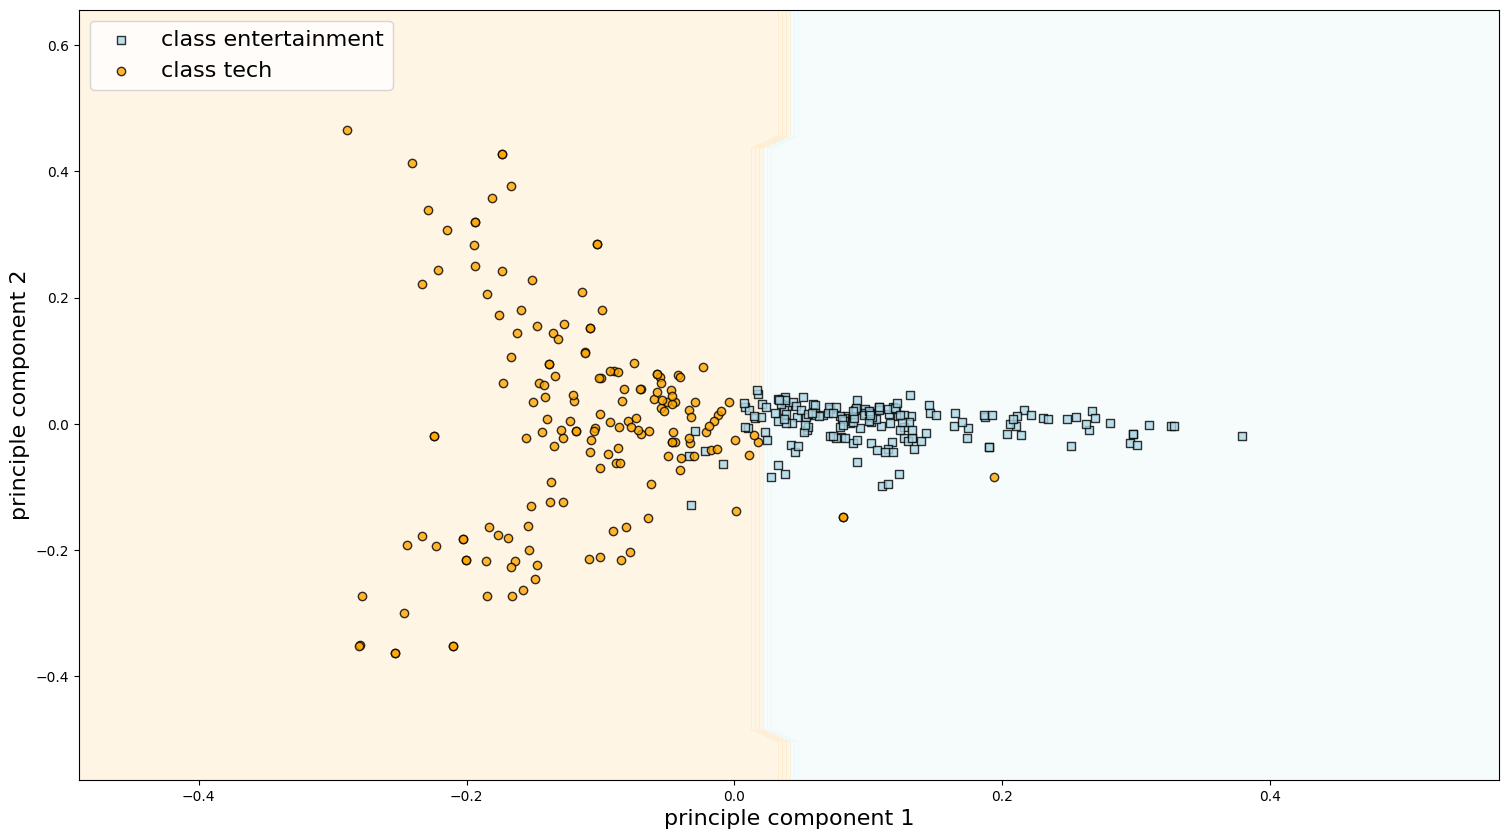

In [26]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn, pca_train_tfidf, y_train_rbf, ax_pca, rbf_svm, test_idx=None, resolution=0.02)


(56, 38)


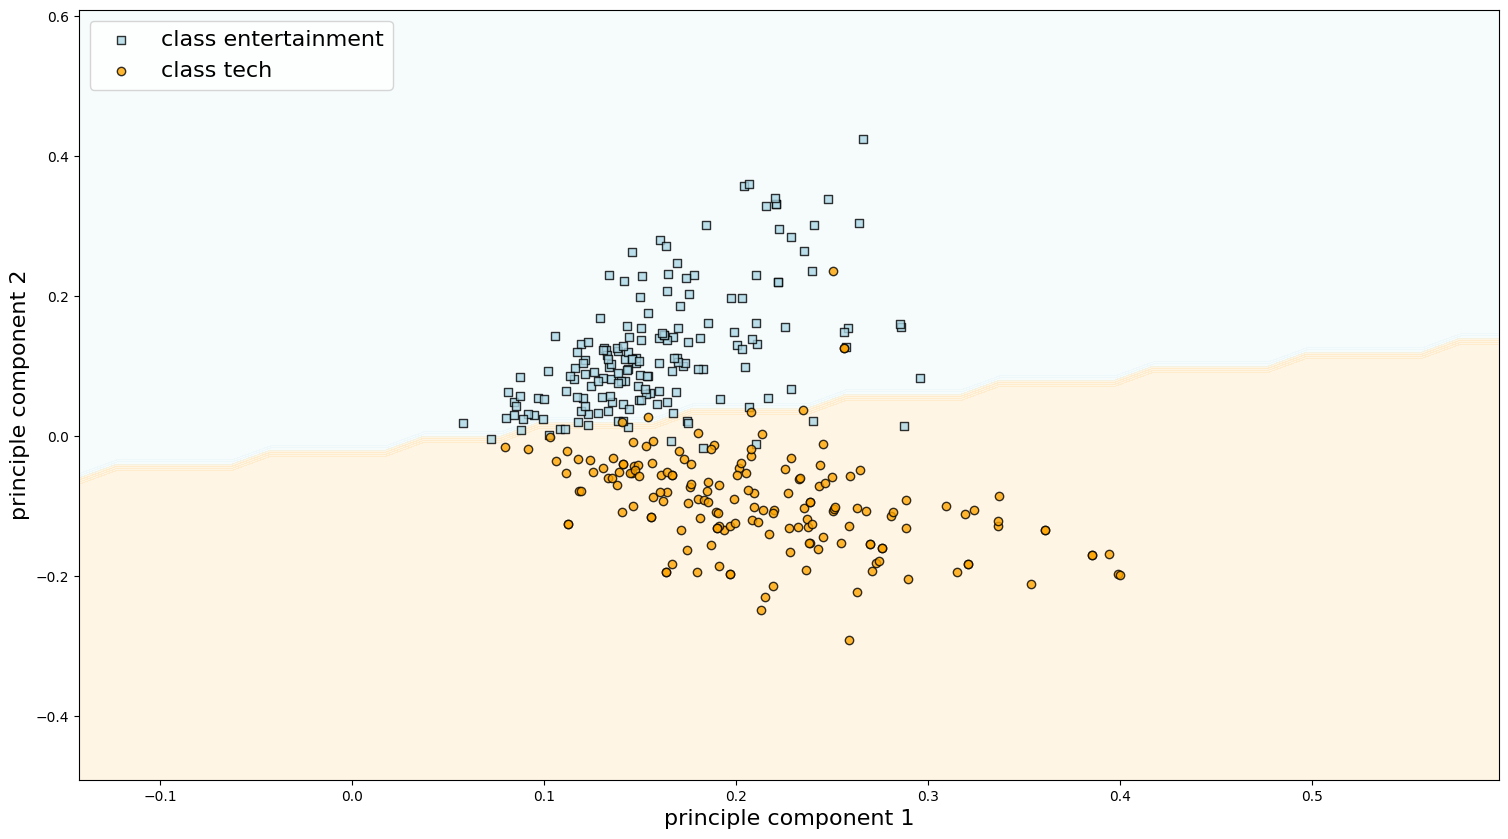

In [27]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(pca_knn_trunc, pca_train_tfidf_trunc, y_train_rbf, ax_pca, rbf_svm, test_idx=None, resolution=0.02)


### d) Neural Network

## Task 3: Classification Quality Evaluation

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.


Train on train data

Predict on testing data: test once for each model




(c) Report and compare your NB, kNN, SVM and NN classifiers with the best hyperparameter
settings. Summarize what you have observed in the classification accuracy in 𝐹𝐹1 measure on
the testing dataset. 